In [1]:
import numpy as np
import random 
import gym

import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

from models.TimeSeriesTransformer import *

In [2]:
# enable eager execution
tf.enable_eager_execution()

In [3]:
# seed random number generators for reproducable results
np.random.seed (0)
random.seed(0)
tf.set_random_seed(0)
#tf.random.set_seed(0)

# SAMPLE DATA

In [45]:
# for details see: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
CART_POS="cartPos"
CART_VEL="cartVel"
PEND_POS="pendPos"
PEND_VEL="pendVel"
EPISODE="episode"
STEP="step"
ACTION="action"
    
def sample_data (episodes=10000, seed=0):
    env = gym.make ("CartPole-v1")
    env.np_random.seed(0)
    
    ### CREATE EMPTY Pandas dataset
    transitions = []

    ### SAMPLE DATA
    for episode in range (episodes):
        #print ("Start of episode %d" % episode)
        obs = env.reset()
        step = 0
        done = False

        while step < 500 and not done:
            step += 1
            action = env.action_space.sample()

            transitions.append({CART_POS:obs[0], CART_VEL:obs[1], 
                             PEND_POS:obs[2], PEND_VEL:obs[3],
                             EPISODE:episode, STEP:step, ACTION:action})

            obs, reward, done, _ = env.step(action)

        #print ("  --> finished after %d steps" % step)
        
    return pd.DataFrame(transitions)


df = sample_data(episodes=200, seed=0)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

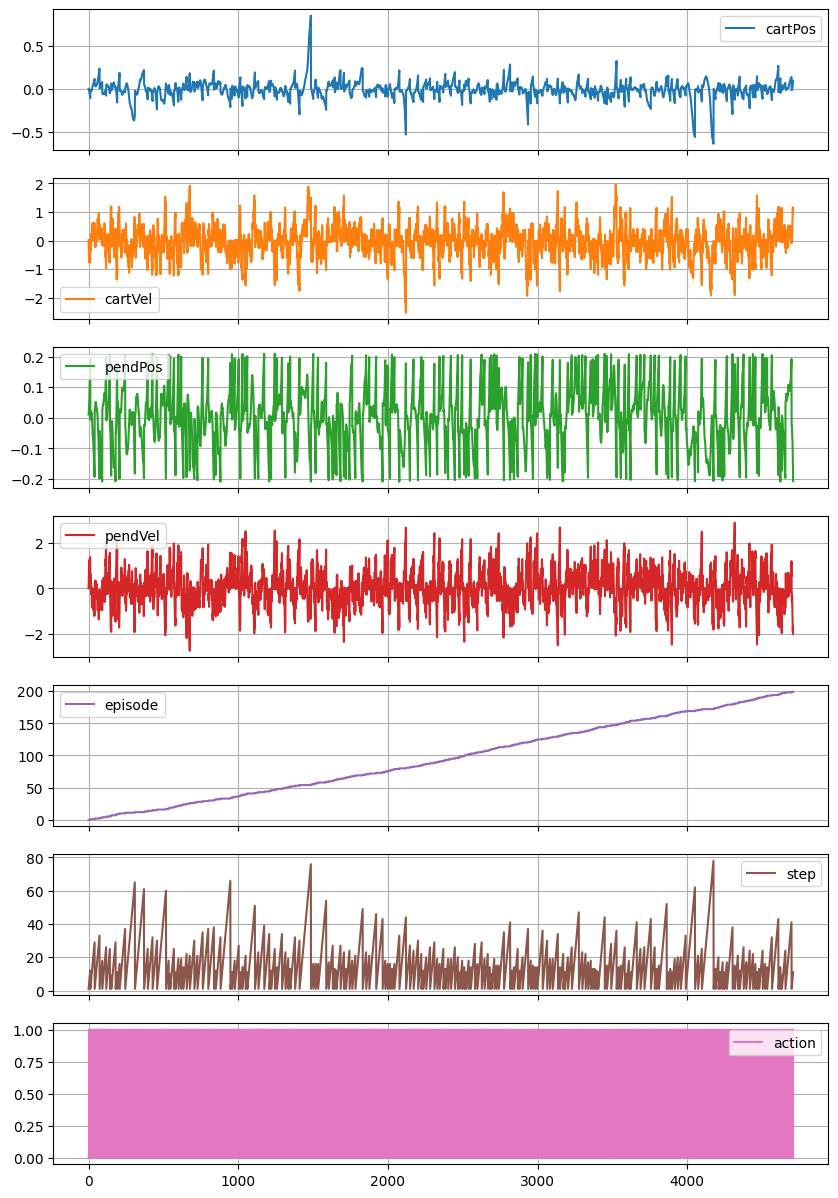

In [46]:
df.plot(subplots=True, figsize=(10,15), grid=True)

In [33]:
def plot_quantiles(var_name, bucket_size, title):
    plt.figure(figsize=(12,5))
    plt.hist(df[var_name], bins=50, alpha=0.5, label=var_name)

    quantile = 0

    while quantile <= 100:
        plt.axvline(df[var_name].quantile(quantile/100), color='b', linestyle='dashed', linewidth=1)
        quantile += bucket_size

    plt.grid()
    plt.title(title)
    plt.show()

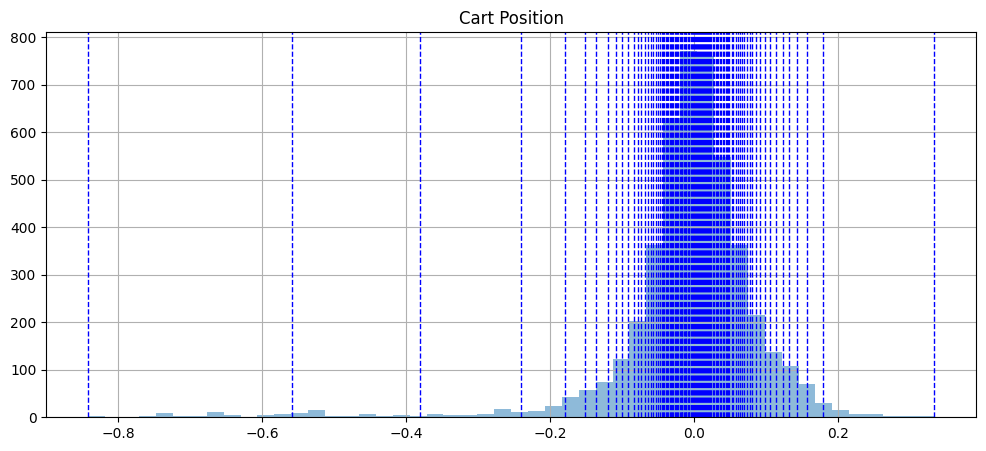

In [7]:
plot_quantiles(CART_POS, bucket_size=1, title="Cart Position")

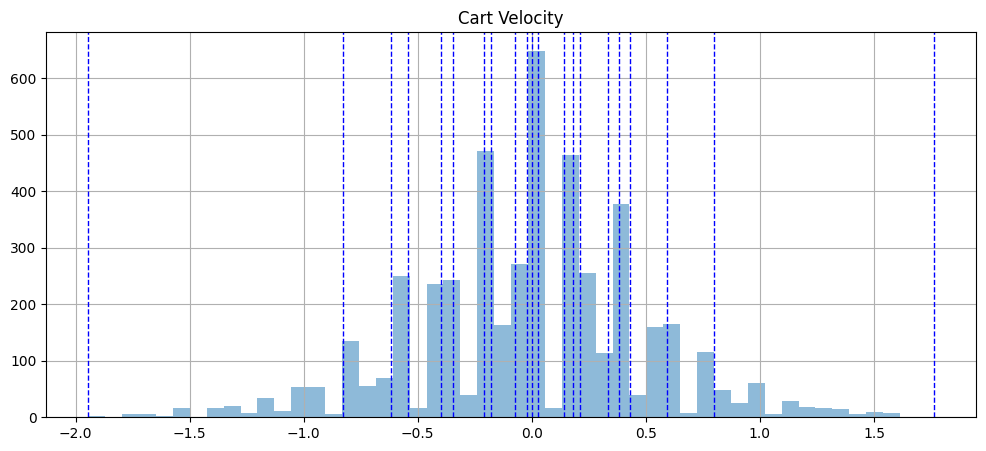

In [34]:
plot_quantiles(CART_VEL, bucket_size=5, title="Cart Velocity")

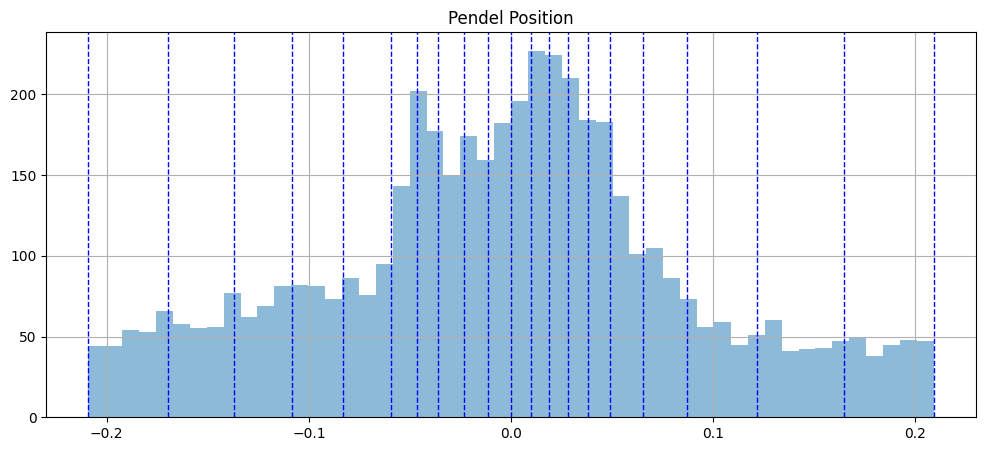

In [35]:
plot_quantiles(PEND_POS, bucket_size=5, title="Pendel Position")

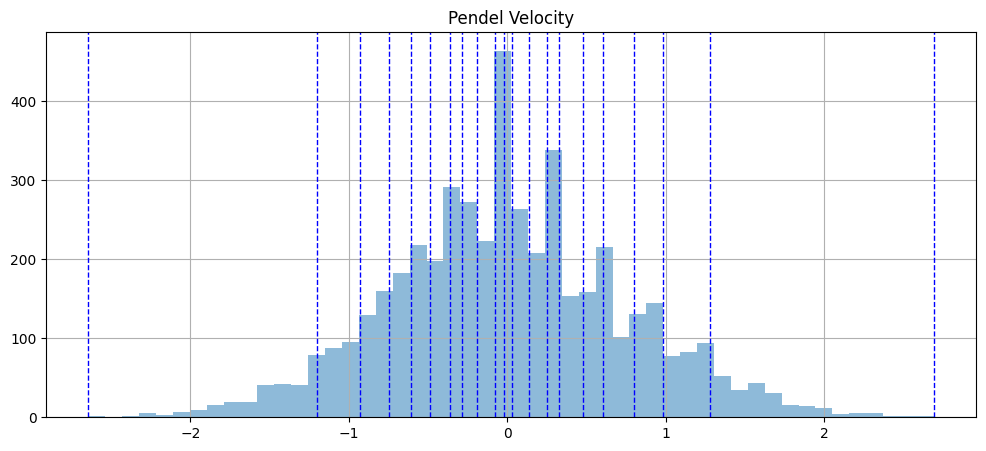

In [36]:
plot_quantiles(PEND_VEL, bucket_size=5, title="Pendel Velocity")

In [37]:
step_size = 5

# Initialize the quantiles list with the starting value
quantiles = [0]

i = step_size
while i <= 100:
    quantiles.append(i)
    i += step_size

# Discretize into quantiles
cart_pos_quantile_values = [
    df[CART_POS].quantile(q/100) for q in quantiles
]
cart_vel_quantile_values = [
    df[CART_VEL].quantile(q/100) for q in quantiles
]
pend_pos_quantile_values = [
    df[PEND_POS].quantile(q/100) for q in quantiles
]
pend_vel_quantile_values = [
    df[PEND_VEL].quantile(q/100) for q in quantiles
]

In [38]:
def bucketize_cart_pos(value):

    for i, v in enumerate(cart_pos_quantile_values):
        if value <= v:
            return i
        
    return i + 1

def bucketize_cart_vel(value):

    for i, v in enumerate(cart_vel_quantile_values):
        if value <= v:
            return i
        
    return i + 1 
def bucketize_pend_pos(value):

    for i, v in enumerate(pend_pos_quantile_values):
        if value <= v:
            return i
        
    return i + 1 
def bucketize_pend_vel(value):

    for i, v in enumerate(pend_vel_quantile_values):
        if value <= v:
            return i
        
    return i + 1 

# GENERATE PATTERN DATA

In [39]:
#############################################
#### HELPER FUNCTIONS FOR PATTERN GENERATION
#############################################
def create_training_data(data, input_col, target_col, window_size=1, training_pattern_percent=0.7):

    data_train = data

    mean_in, std_in = mean_and_std(input_col, data_train)
    mean_out, std_out = mean_and_std(target_col, data_train)
    #data_plot.plot_hist_df(data_train, input_col)
    #data_plot.plot_timeseries_df(data_train, input_col)
    print(f"mean in = {mean_in}" )
    print(f"std in = {std_in}")
    print(f"mean out =  {mean_out}")
    print(f"std out = {std_out}")

    grouped = data_train.groupby(['episode'])

    inputs_all = []
    labels_all = []

    for g in grouped:
        # be sure that data inside a group is not shuffled # not sure if needed
        g = g[1].sort_values(by='step')

        past_history = window_size   # t-3, t-2, t-1, t
        future_target = 0  # t+1
        STEP = 1 # no subsampling of rows in data, e.g. only every i'th row

        # use pandas.DataFrame.values in order to get an numpy array from an pandas.DataFrame object

        inputs, labels = multivariate_data(dataset=g[input_col][:].values, target=g[target_col][:].values,
                                        start_index=0, end_index=g[input_col][:].values.shape[0]-future_target,
                                        history_size=past_history, target_size=future_target, step=STEP,
                                        single_step=True)

        ## Append data to whole set of patterns
        for i in range (0, len(inputs)):
            inputs_all.append(inputs[i])
            labels_all.append(labels[i])
  
    length = len(inputs_all)

    c = list(zip(inputs_all, labels_all))
    np.random.shuffle(c)
    inputs_all, labels_all = zip(*c)

    split = int(training_pattern_percent * length)

    inputs_all = np.array(inputs_all)
    labels_all = np.array(labels_all)

    return ((inputs_all[0:split], labels_all[0:split]), (inputs_all[split:], labels_all[split:])), mean_in, std_in, mean_out, std_out


def mean_and_std(columns, data):
    mean = np.zeros(len(columns))
    std = np.zeros(len(columns))
    index = 0
    for c in columns:
        mean[index], std[index] = get_normalizations(data[c])
        index = index + 1
    return mean, std

def get_normalizations(data):
    mean = data.mean()
    std = data.std()
    return mean, std

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
       end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)



def prepare_data(df, input_col, target_col, window_size, training_batch_size=50, validation_batch_size=50, training_pattern_percent=0.7):
    
    global x_train_multi, y_train_multi
    
    ###################
    ## PREPARE DATASET
    ###################
    ((x_train_multi, y_train_multi), (x_val_multi, y_val_multi)), mean_in, std_in, mean_out, std_out = \
                                    create_training_data(df, input_col, target_col, window_size=window_size,
                                                        training_pattern_percent=training_pattern_percent)

    print('trainData: Single window of past history : {}'.format(x_train_multi[0].shape))
    print('trainData: Single window of future : {}'.format(y_train_multi[1].shape))
    print('valData: Single window of past history : {}'.format(x_val_multi[0].shape))
    print('valData: Single window of future : {}'.format(y_val_multi[1].shape))
    print('trainData: number of trainingsexamples: {}'.format(x_train_multi.shape))
    print('valData: number of trainingsexamples: {}'.format(x_val_multi.shape))

    train_data = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    #train_data = train_data.cache().shuffle(max_training_pattern).batch(training_batch_size).repeat()
    train_data = train_data.shuffle(x_train_multi.shape[0]).batch(training_batch_size).repeat()

    val_data = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data = val_data.batch(validation_batch_size).repeat()
    input_shape = x_train_multi[0].shape[-2:]
    return train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out


In [40]:
bucket_df = df.copy()
bucket_df[CART_POS] = bucket_df[CART_POS].apply(lambda x: bucketize_cart_pos(x))
bucket_df[CART_VEL] = bucket_df[CART_VEL].apply(lambda x: bucketize_cart_vel(x))
bucket_df[PEND_POS] = bucket_df[PEND_POS].apply(lambda x: bucketize_pend_pos(x))
bucket_df[PEND_VEL] = bucket_df[PEND_VEL].apply(lambda x: bucketize_pend_vel(x))

In [41]:
window_size=4
input_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL, ACTION]
target_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out =  \
            prepare_data(bucket_df, input_col, target_col, window_size=window_size, training_pattern_percent=0.7)

print ("Input-Shape: ", input_shape)

mean in = [10.49937448 10.49937448 10.49937448 10.49937448  0.4912427 ]
std in = [5.76818425 5.76818425 5.76818425 5.76818425 0.49997543]
mean out =  [10.49937448 10.49937448 10.49937448 10.49937448]
std out = [5.76818425 5.76818425 5.76818425 5.76818425]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (2797, 4, 5)
valData: number of trainingsexamples: (1199, 4, 5)
Input-Shape:  (4, 5)


# Create Transformer Model

In [16]:
# Transformer Parameters
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_shape = (50, 4, 5)

pos_encoding = positional_encoding(50, d_model)

In [17]:

# Define model parameters
modelpath = "transformer_model"
max_epochs = 1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

# Define callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1)
#mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}.bestTrainLoss", monitor='loss', verbose=1, save_best_only=True, mode='min')
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}/model.bestValLoss", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=r"./model_logs_tb", histogram_freq=1)

# Ensure your model is defined
model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
model.compile(optimizer='adam', loss='mse')

# Fit the model
history = model.fit(
    train_data,
    epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    validation_freq=validation_freq,
    callbacks=[
        #mc_trainLoss_callback,
        mc_valLoss_callback,
        es_callback, 
        #tensorboard_callback
    ]
)

# Save the model
model.save(modelpath, save_format='tf')


Train for 100 steps, validate for 100 steps
Epoch 1/1000
 96/100 [===========================>..] - ETA: 0s - loss: 1759.8750
Epoch 00001: val_loss improved from inf to 1285.15364, saving model to transformer_model/model.bestValLoss
100/100 [==============================] - 3s 33ms/step - loss: 1740.8683 - val_loss: 1285.1536
Epoch 2/1000
 96/100 [===========================>..] - ETA: 0s - loss: 1084.7252
Epoch 00002: val_loss improved from 1285.15364 to 968.16065, saving model to transformer_model/model.bestValLoss
100/100 [==============================] - 1s 13ms/step - loss: 1080.3540 - val_loss: 968.1607
Epoch 3/1000
 96/100 [===========================>..] - ETA: 0s - loss: 916.9064
Epoch 00003: val_loss improved from 968.16065 to 886.16779, saving model to transformer_model/model.bestValLoss
100/100 [==============================] - 1s 13ms/step - loss: 915.4631 - val_loss: 886.1678
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 741.9403
Epoch 00004: 

# Evaluate model quality

### Sample new data from environment and determine episode with most steps

In [24]:
dfEval = sample_data(episodes=100, seed=111)
dfEval.describe()
row_max_steps = dfEval[dfEval.step == dfEval.step.max()]
dfEval = dfEval[dfEval.episode==int(row_max_steps.episode)]

### Extract prediction bounds from training data

In [25]:
output_min = y_train_multi.min(axis=0)
output_max = y_train_multi.max(axis=0)
print ("min(output)_data: ", output_min)
print ("max(output)_data: ", output_max)

min(output)_data:  [0. 0. 0. 0.]
max(output)_data:  [100. 100. 100. 100.]


### Evaluate transformer

In [26]:
import collections


# Define custom objects dictionary
custom_objects = {
    'TimeSeriesTransformer': TimeSeriesTransformer,
    'Encoder': Encoder,
    'EncoderLayer': EncoderLayer,
    'MultiHeadAttention': MultiHeadAttention,
    'point_wise_feed_forward_network': point_wise_feed_forward_network
}

# Load the saved model with custom objects
modelpath = "transformer_model"
transformer_model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
transformer_model.load_weights(f"{modelpath}/model.bestValLoss")
#lstm_model = tf.keras.models.load_model("model.h5")

In [27]:
dfEval[CART_POS] = dfEval[CART_POS].apply(lambda x: bucketize_cart_pos(x))
dfEval[CART_VEL] = dfEval[CART_VEL].apply(lambda x: bucketize_cart_vel(x))
dfEval[PEND_POS] = dfEval[PEND_POS].apply(lambda x: bucketize_pend_pos(x))
dfEval[PEND_VEL] = dfEval[PEND_VEL].apply(lambda x: bucketize_pend_vel(x))

In [28]:
# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        
        netOutput = transformer_model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))
        
transformer_dfNet = pd.DataFrame(transitions)

[[[62.       36.       41.       67.        0.      ]
  [59.       24.       43.       80.        1.      ]
  [54.       36.       48.       66.        1.      ]
  [50.014297 56.464127 53.560135 45.681374  1.      ]]]


In [29]:
# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        
        netOutput = lstm_model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))
        
lstm_dfNet = pd.DataFrame(transitions)

NameError: name 'lstm_model' is not defined

In [ ]:
transformer_dfNet

,cartPos,cartVel,pendPos,pendVel
0,5.128652,5.405730,5.684157,6.027701
1,5.080427,7.177658,5.901230,4.318932
2,5.444527,5.600135,5.589406,6.126377
3,5.557368,3.901287,5.733236,7.432169
4,5.184588,2.845258,5.940499,8.525438
5,4.465595,3.905740,7.019143,7.536052
6,4.012648,5.284205,7.141020,6.105856
7,4.183542,4.022743,7.186290,7.587731
8,3.777112,5.144052,7.531968,6.235909
9,3.762088,6.965147,7.673604,4.901143


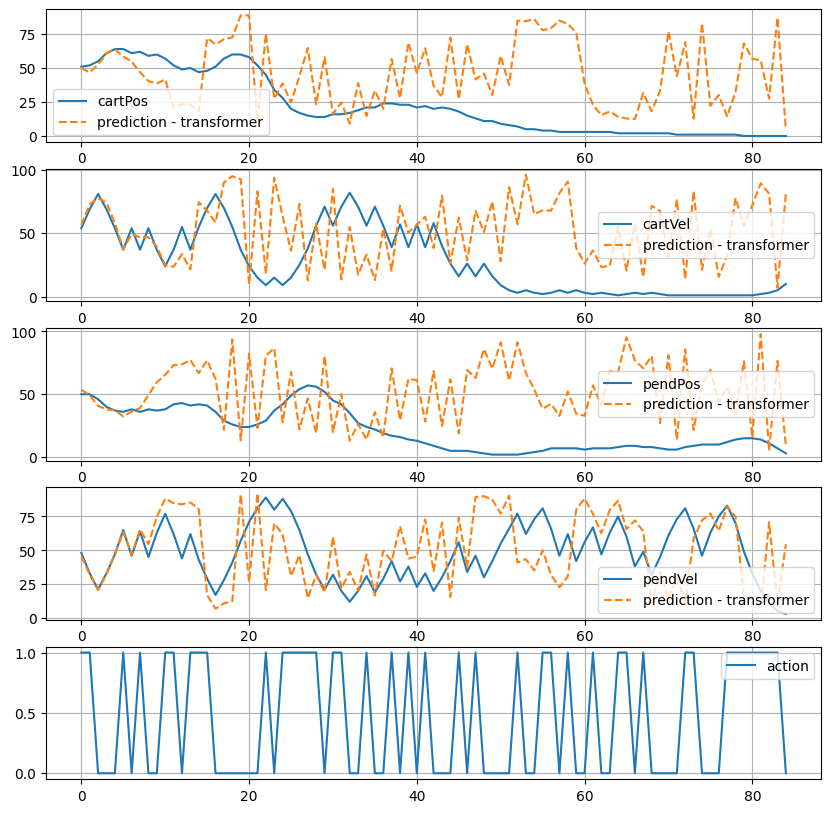

In [30]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(transformer_dfNet)), dfEval[f].values[window_size:window_size+len(transformer_dfNet)], label=f)
    axs[i].plot(range (len(transformer_dfNet)), transformer_dfNet[f].values, label="prediction - transformer", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(transformer_dfNet)), dfEval[ACTION].values[window_size:window_size+len(transformer_dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")

plt.show()

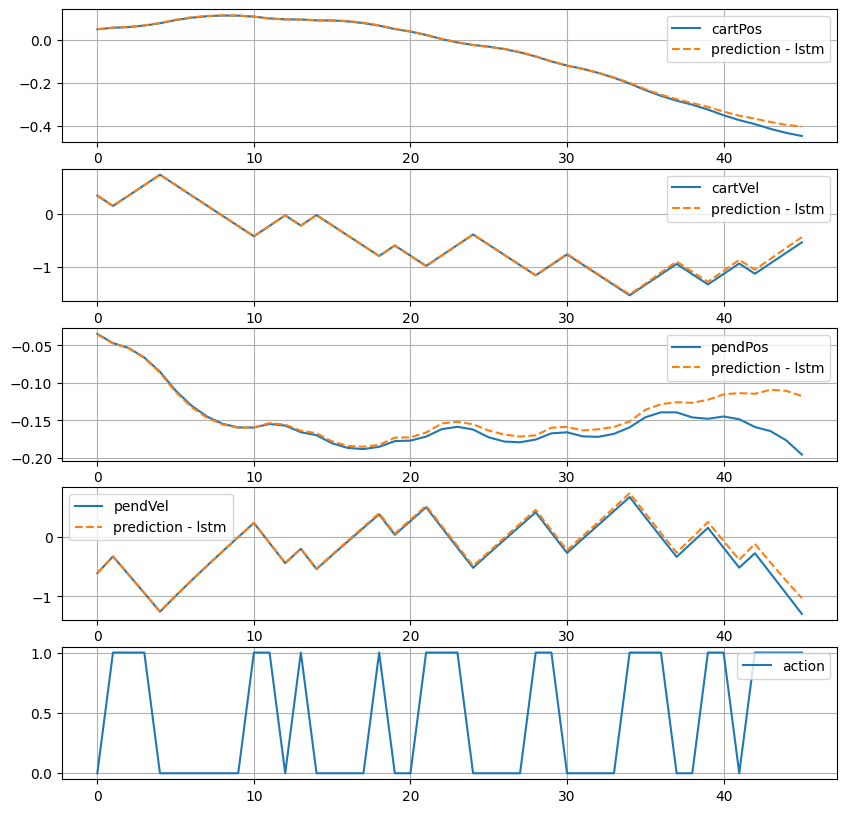

In [ ]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(lstm_dfNet)), dfEval[f].values[window_size:window_size+len(lstm_dfNet)], label=f)
    axs[i].plot(range (len(lstm_dfNet)), lstm_dfNet[f].values, label="prediction - lstm", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(lstm_dfNet)), dfEval[ACTION].values[window_size:window_size+len(lstm_dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")

plt.show()

In [ ]:

if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


# New Version

In [42]:
# CART_VEL = "cartVel"
# PEND_VEL = "pendVel"
# EPISODE = "episode"
# STEP = "step"
# ACTION = "action"

# def sample_data(episodes=10000, seed=0):
#     env = gym.make("CartPole-v1")
#     env.np_random.seed(seed)
    
#     ### CREATE EMPTY Pandas dataset
#     transitions = []

#     ### SAMPLE DATA
#     for episode in range(episodes):
#         obs = env.reset()
#         step = 0
#         done = False

#         while step < 500 and not done:
#             step += 1
#             action = env.action_space.sample()

#             # Only save velocities in the dataset
#             transitions.append({
#                 CART_VEL: obs[1], 
#                 PEND_VEL: obs[3],
#                 EPISODE: episode, 
#                 STEP: step, 
#                 ACTION: action
#             })

#             obs, reward, done, _ = env.step(action)

#     return pd.DataFrame(transitions)

# # Generate sample data with the modified function
# df = sample_data(episodes=200, seed=0)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

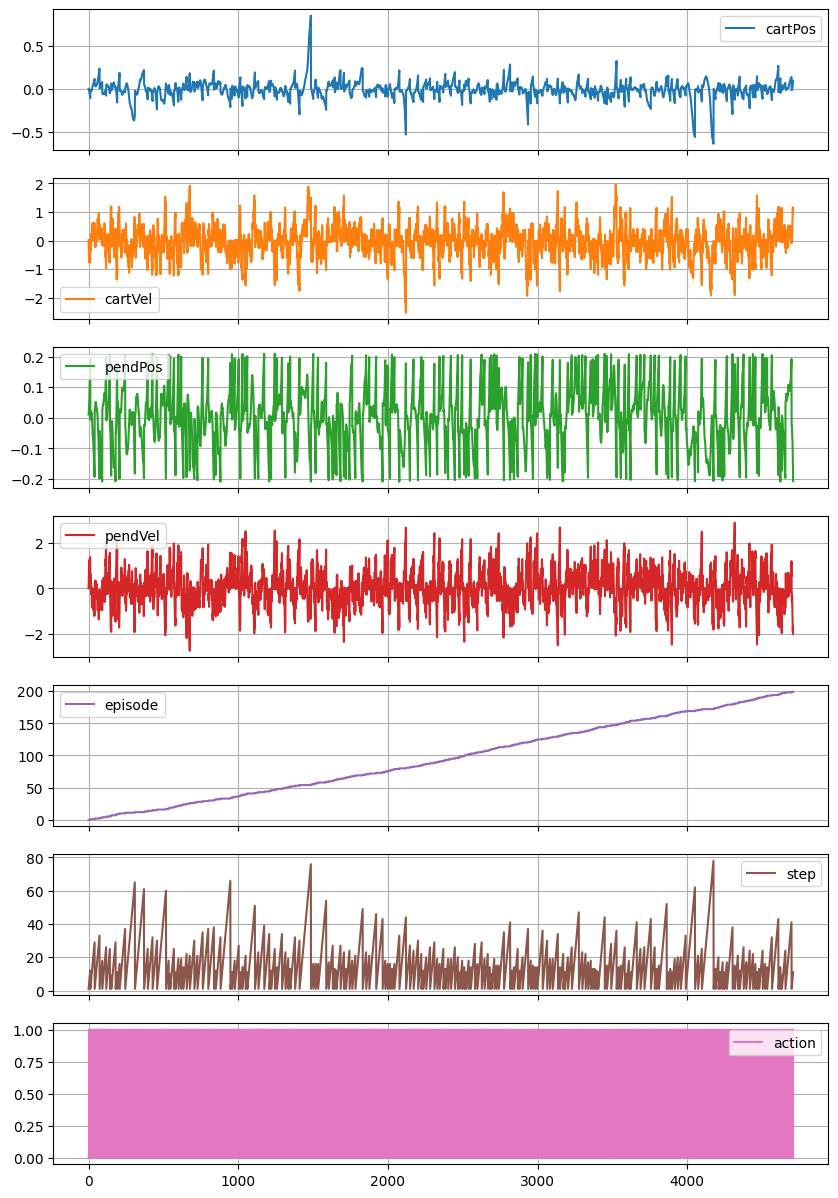

In [84]:
df.plot(subplots=True, figsize=(10,15), grid=True)

In [85]:
bucket_df = df.copy()
bucket_df[CART_POS] = bucket_df[CART_POS].apply(lambda x: bucketize_cart_pos(x))
bucket_df[CART_VEL] = bucket_df[CART_VEL].apply(lambda x: bucketize_cart_vel(x))
bucket_df[PEND_POS] = bucket_df[PEND_POS].apply(lambda x: bucketize_pend_pos(x))
bucket_df[PEND_VEL] = bucket_df[PEND_VEL].apply(lambda x: bucketize_pend_vel(x))

In [86]:
window_size=4
input_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL, ACTION]
target_col = [CART_VEL, PEND_VEL]

train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out =  \
            prepare_data(bucket_df, input_col, target_col, window_size=window_size, training_pattern_percent=0.7)

print ("Input-Shape: ", input_shape)

mean in = [ 9.95433305 10.18415463 10.97642311 10.86873407  0.49256585]
std in = [5.74360437 5.82255378 5.70901179 5.78572262 0.49999783]
mean out =  [10.18415463 10.86873407]
std out = [5.82255378 5.78572262]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (2,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (2,)
trainData: number of trainingsexamples: (2735, 4, 5)
valData: number of trainingsexamples: (1173, 4, 5)
Input-Shape:  (4, 5)


In [87]:
# Transformer Parameters
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_shape = (50, 4, 5)

pos_encoding = positional_encoding(50, d_model)

In [89]:
@tf.function
def masked_mse(y_true, y_pred):
    # Assuming y_true has shape [batch_size, seq_len, 4] 
    # and y_pred has shape [batch_size, seq_len, 2]
    
    # Extract only the velocity targets from y_true
    y_true_vel = y_true[..., 1:2]  # CART_VEL
    y_true_vel = tf.concat([y_true_vel, y_true[..., 3:4]], axis=-1)  # PEND_VEL
    
    # Compute the MSE between the velocity targets and predictions
    mse = tf.reduce_mean(tf.square(y_true_vel - y_pred))
    
    return mse


In [90]:
# Define model parameters
modelpath = "transformer_model_vel_only"
max_epochs = 1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

# Define callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1)
#mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}.bestTrainLoss", monitor='loss', verbose=1, save_best_only=True, mode='min')
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}/model.bestValLoss", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=r"./model_logs_tb", histogram_freq=1)

# Ensure your model is defined
model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
model.compile(optimizer='adam', loss=masked_mse)

# Fit the model
history = model.fit(
    train_data,
    epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    validation_freq=validation_freq,
    callbacks=[
        #mc_trainLoss_callback,
        mc_valLoss_callback,
        es_callback, 
        #tensorboard_callback
    ]
)

# Save the model
# model.save(modelpath, save_format='tf')

()
Train for 100 steps, validate for 100 steps
Epoch 1/1000
()
 98/100 [============================>.] - ETA: 0s - loss: 17.1904
Epoch 00001: val_loss improved from inf to 12.02228, saving model to transformer_model_vel_only/model.bestValLoss
100/100 [==============================] - 3s 33ms/step - loss: 17.0622 - val_loss: 12.0223
Epoch 2/1000
 97/100 [============================>.] - ETA: 0s - loss: 10.2694
Epoch 00002: val_loss improved from 12.02228 to 10.51001, saving model to transformer_model_vel_only/model.bestValLoss
100/100 [==============================] - 1s 15ms/step - loss: 10.2473 - val_loss: 10.5100
Epoch 3/1000
 98/100 [============================>.] - ETA: 0s - loss: 8.0052
Epoch 00003: val_loss improved from 10.51001 to 4.31443, saving model to transformer_model_vel_only/model.bestValLoss
100/100 [==============================] - 1s 14ms/step - loss: 7.9776 - val_loss: 4.3144
Epoch 4/1000
 96/100 [===========================>..] - ETA: 0s - loss: 4.8225
Epoch 0

KeyboardInterrupt: 

# Evaluation

In [80]:
dfEval = sample_data(episodes=100, seed=111)
dfEval.describe()
row_max_steps = dfEval[dfEval.step == dfEval.step.max()]
dfEval = dfEval[dfEval.episode==int(row_max_steps.episode)]

In [81]:
output_min = y_train_multi.min(axis=0)
output_max = y_train_multi.max(axis=0)
print ("min(output)_data: ", output_min)
print ("max(output)_data: ", output_max)

min(output)_data:  [0. 0.]
max(output)_data:  [21. 21.]


In [82]:
import collections


# Define custom objects dictionary
custom_objects = {
    'TimeSeriesTransformer': TimeSeriesTransformer,
    'Encoder': Encoder,
    'EncoderLayer': EncoderLayer,
    'MultiHeadAttention': MultiHeadAttention,
    'point_wise_feed_forward_network': point_wise_feed_forward_network
}

# Load the saved model with custom objects
modelpath = "transformer_model_vel_only"
transformer_model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
transformer_model.load_weights(f"{modelpath}/model.bestValLoss")
#lstm_model = tf.keras.models.load_model("model.h5")

In [83]:
netOutput = transformer_model.predict(np.float32(state))[0]
netOutput.shape

(4,)

In [70]:
dfEval[CART_POS] = dfEval[CART_POS].apply(lambda x: bucketize_cart_pos(x))
dfEval[CART_VEL] = dfEval[CART_VEL].apply(lambda x: bucketize_cart_vel(x))
dfEval[PEND_POS] = dfEval[PEND_POS].apply(lambda x: bucketize_pend_pos(x))
dfEval[PEND_VEL] = dfEval[PEND_VEL].apply(lambda x: bucketize_pend_vel(x))

In [99]:
# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        
        netOutput = transformer_model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        # netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:0, CART_VEL:netOutput[1],
            PEND_POS:0, PEND_VEL:netOutput[3]
        })
        
        # # update RNN state
        # stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
        #                                netOutput[2], netOutput[3], 
        #                                dfEval[ACTION].values[i]]))
        # Update RNN state - notice we use the predicted velocities but retain the actual positions
        stateBuffer.append(np.float32([
            dfEval[CART_POS].values[i],  # keep using the actual position
            netOutput[1],  # predicted CART_VEL
            dfEval[PEND_POS].values[i],  # keep using the actual position
            netOutput[3],  # predicted PEND_VEL
            dfEval[ACTION].values[i]
        ]))
        
transformer_dfNet = pd.DataFrame(transitions)

[[[ 0.02147809 -0.20560919  0.00590869  0.2630678   1.        ]
  [ 0.0173659  -0.01057207  0.01117005 -0.0277456   0.        ]
  [ 0.01715446 -0.2058524   0.01061514  0.26844057  1.        ]
  [ 0.01303741  0.76348066  0.01598395  0.7632146   1.        ]]]


c:\Users\gulBa\CodingProjects\reinforcement-learning-project\TimeSeriesTransformer\.venv\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


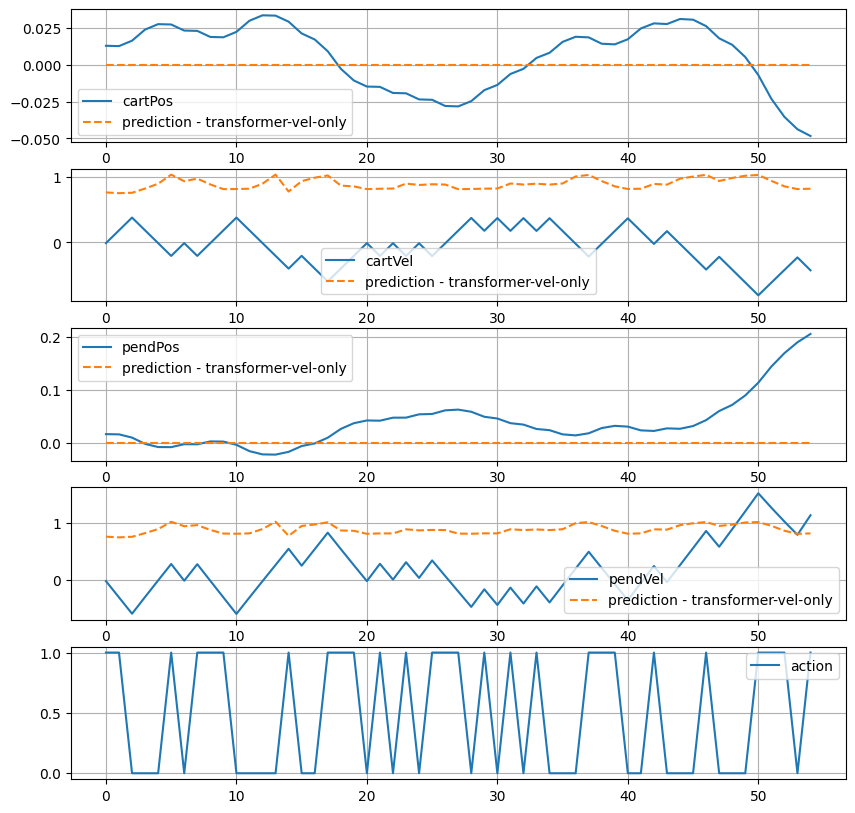

In [100]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(transformer_dfNet)), dfEval[f].values[window_size:window_size+len(transformer_dfNet)], label=f)
    axs[i].plot(range (len(transformer_dfNet)), transformer_dfNet[f].values, label="prediction - transformer-vel-only", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(transformer_dfNet)), dfEval[ACTION].values[window_size:window_size+len(transformer_dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")

plt.show()